# Structure Graphs

Here I get graphs from the contact maps obtained with trRosetta. Residues are nodes and undirected edges exists between residues under a distance treshold.

P62593


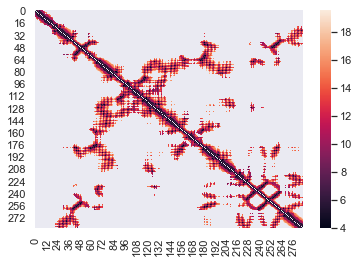

286


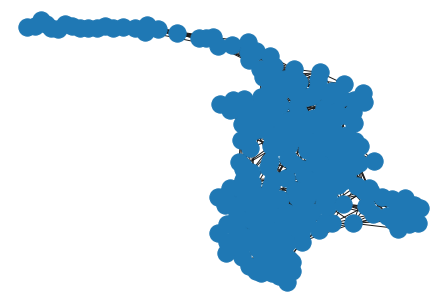

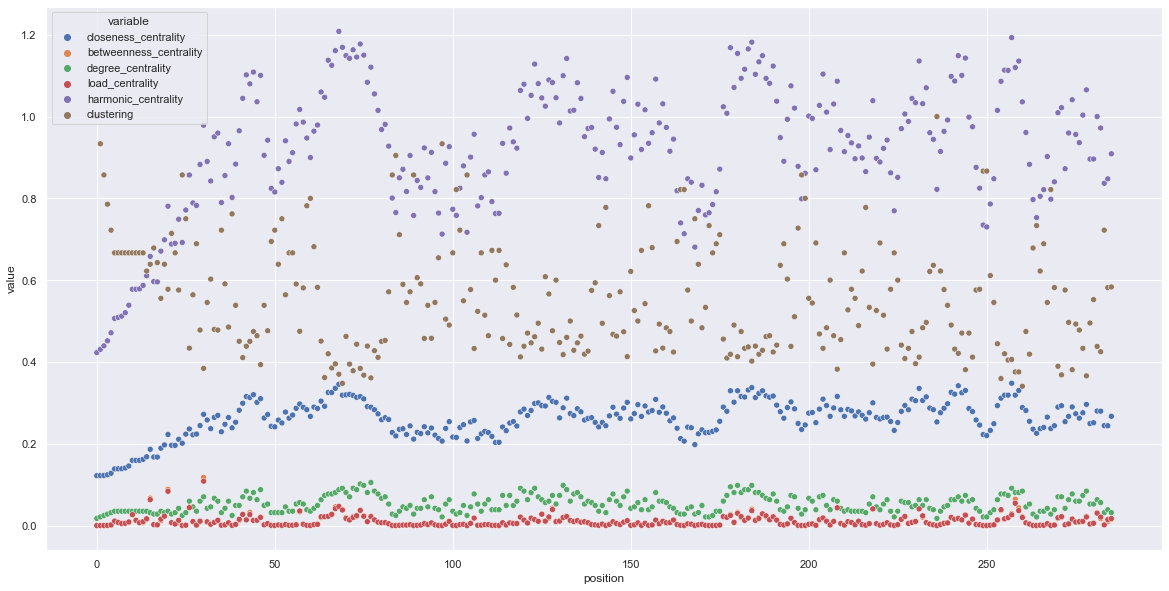

P46937_167-207


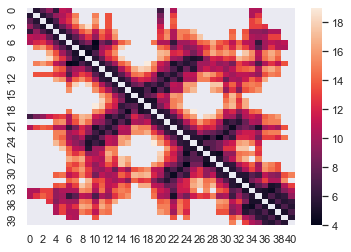

41


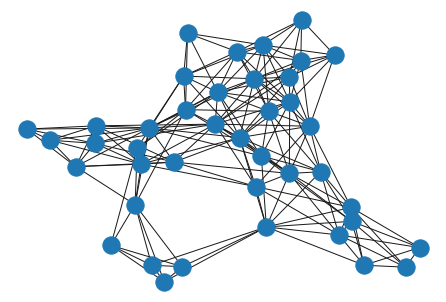

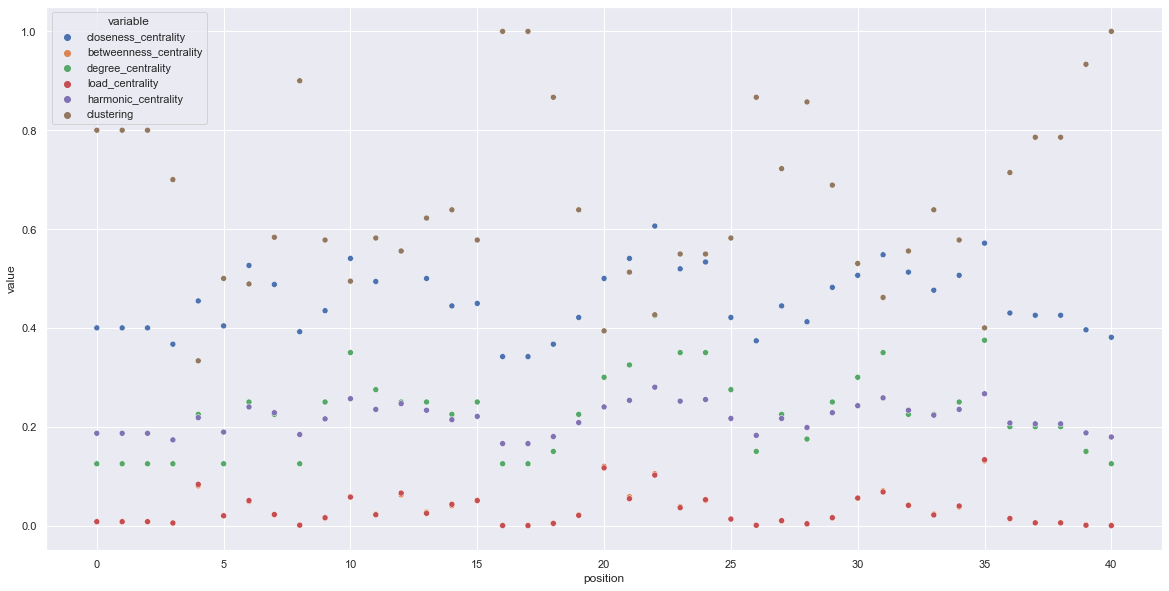

P31016_303-426


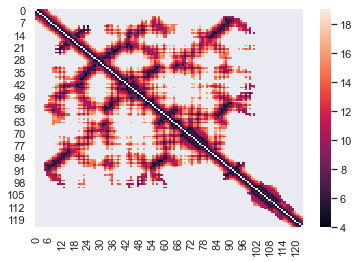

124


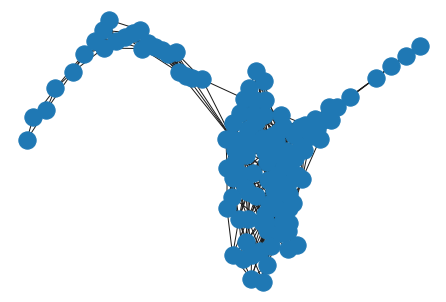

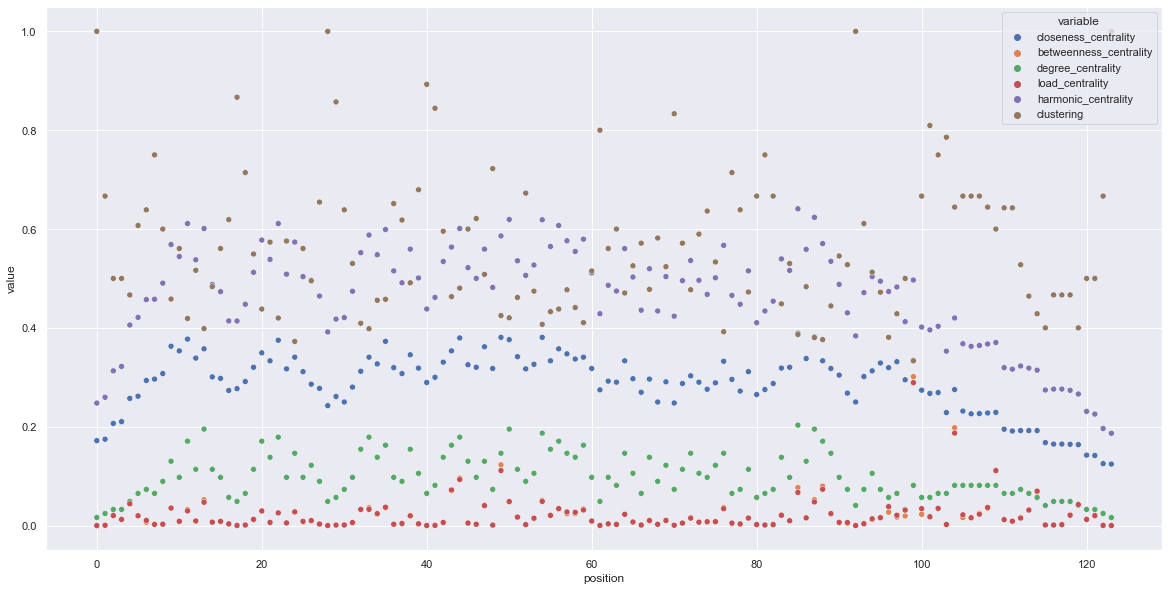

P00552


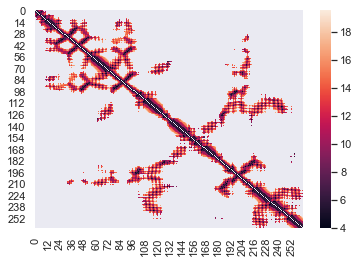

264


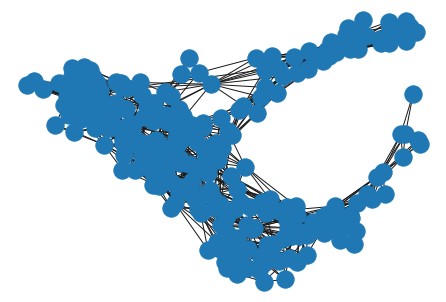

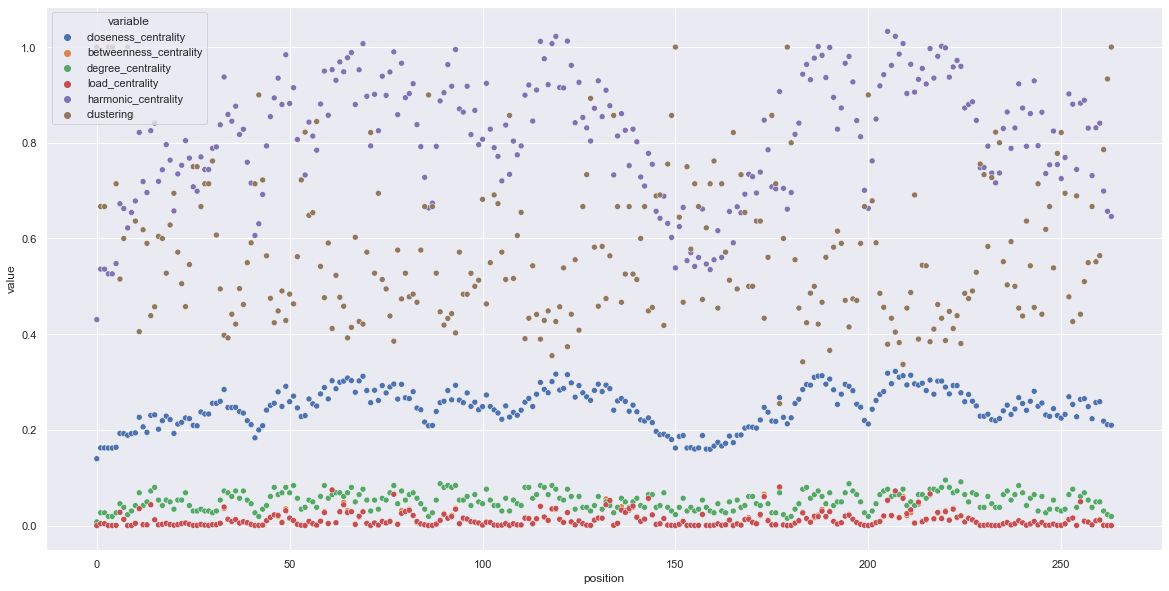

P02829_2-231


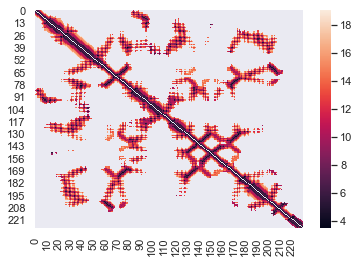

230


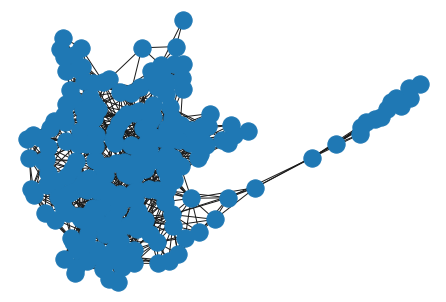

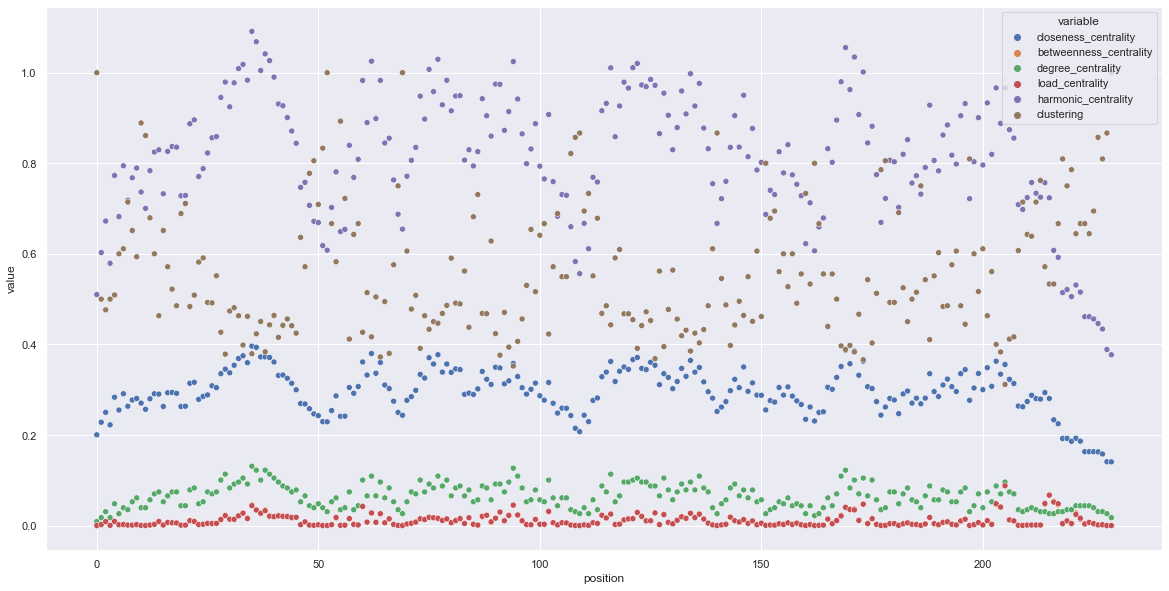

P0CG63_1-76


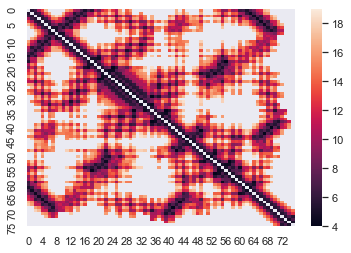

76


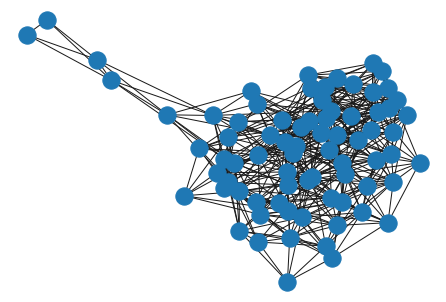

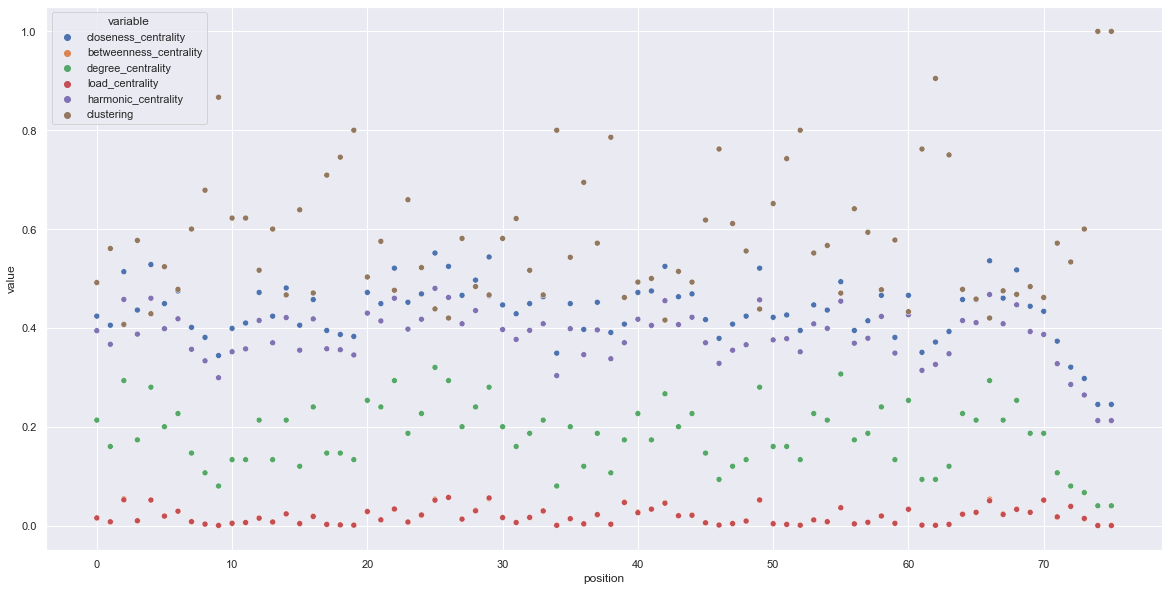

P04147_126-203


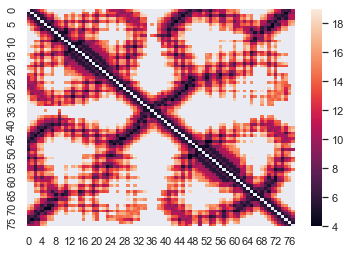

78


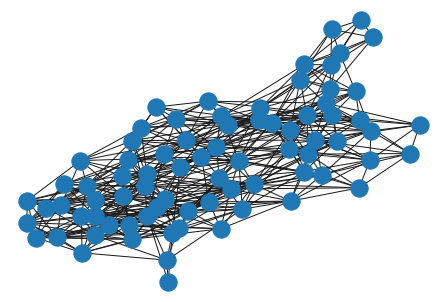

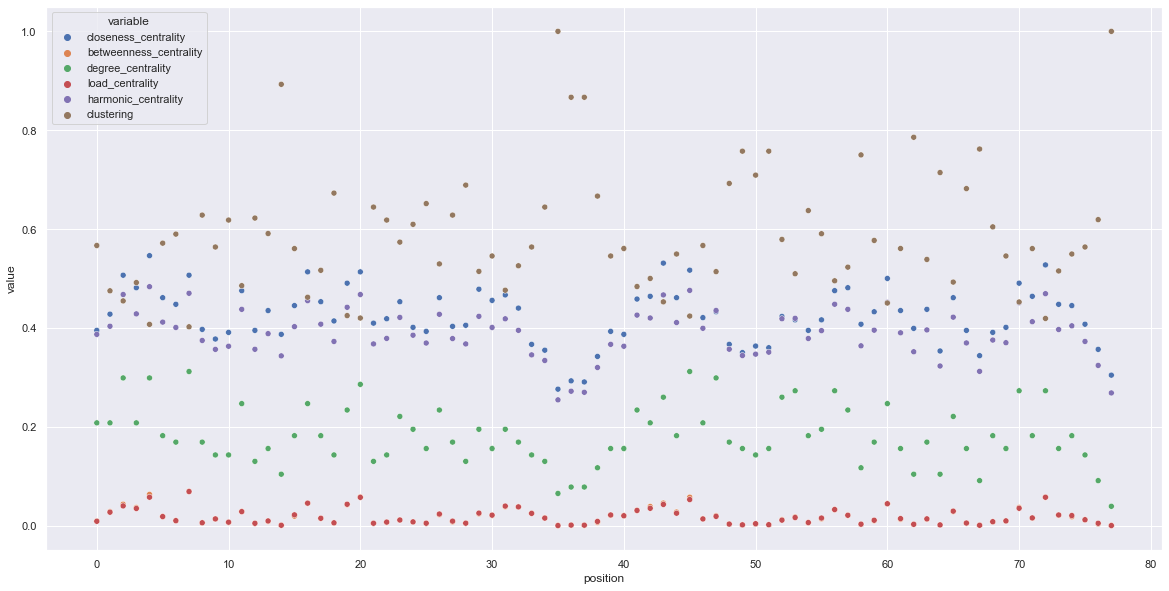

P0CG63_1-76


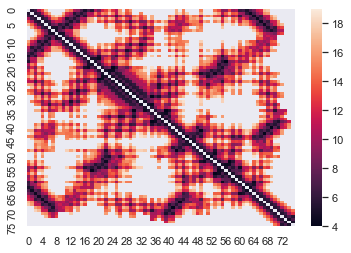

76


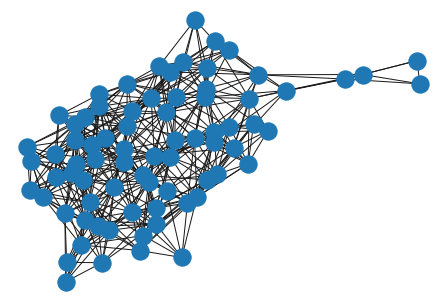

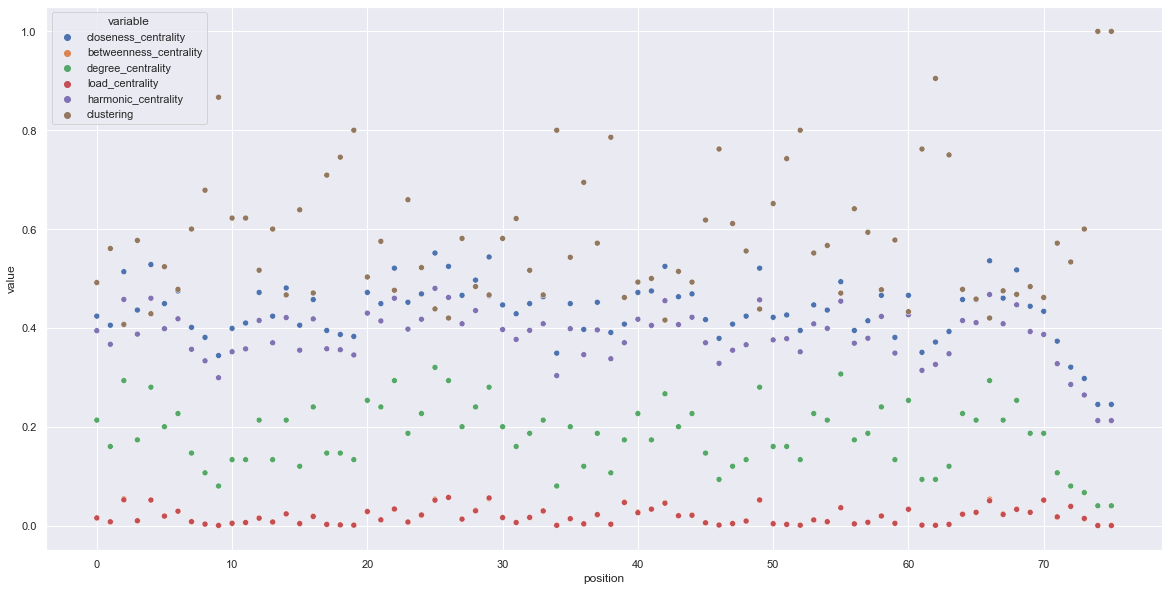

P06654_226-283


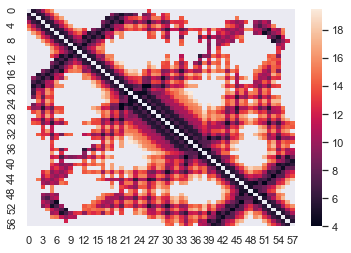

58


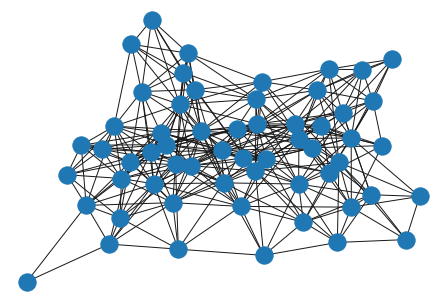

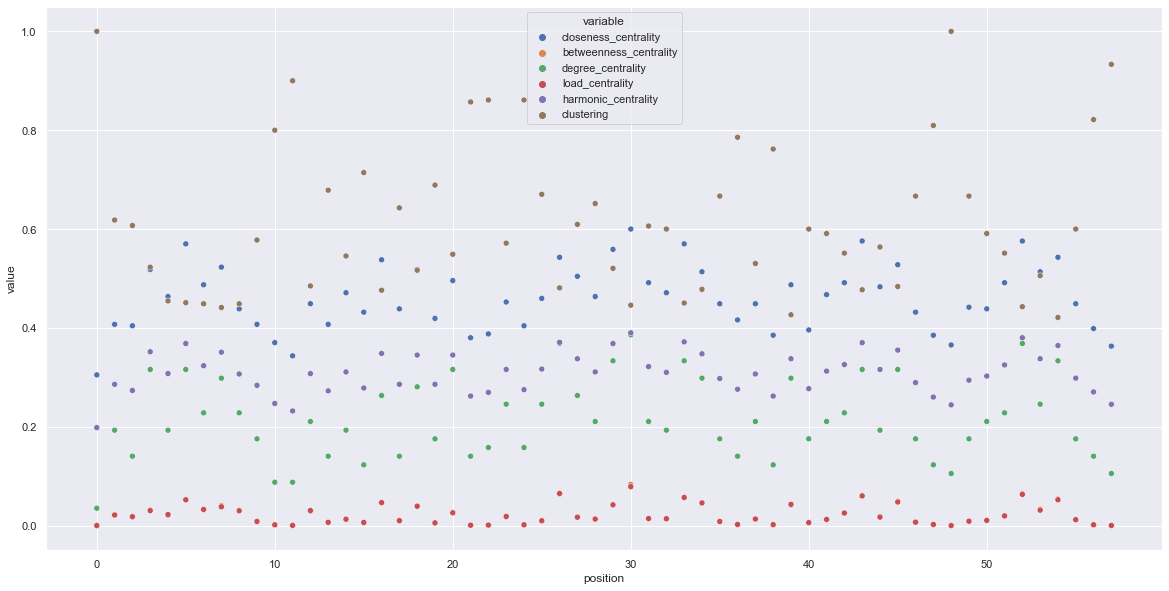

In [29]:
import numpy as np
import seaborn as sns; sns.set()
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

dms_datasets_df = pd.read_csv('/home/saul/master_thesis_work/dataset/dms/dms_datasets.csv')
contact_treshold = 10

# vectorized functions
distogram_bins_map = {i:(dist/10) for i,dist in enumerate([np.nan] + list(range(20,205,5)))}
map_to_dist = np.vectorize(lambda x : distogram_bins_map[x])

for study in dms_datasets_df.dms_id:
    assert len(dms_datasets_df[dms_datasets_df.dms_id == study]) == 1
    basename = set(dms_datasets_df[dms_datasets_df.dms_id == study].feature_basename_trrosetta).pop()
    print(basename)
    # load and show trRosetta cmaps
    distogram = np.load('/home/saul/master_thesis_work/processing/dms/tr_rosetta/' + basename + '_trRosetta.npz')['dist']
    best_bins = np.argmax(distogram, axis=2)
    tr_rosetta_distances = map_to_dist(best_bins)
    plt.close()
    sns.heatmap(tr_rosetta_distances)
    plt.show()
    # create the connection graph
    G = nx.Graph()
    for i, row in enumerate(tr_rosetta_distances):
        G.add_node(i)
        for j, el in enumerate(row):
            if i >= j and el < contact_treshold:
                G.add_edge(i, j)
    print(G.number_of_nodes())
    assert G.number_of_nodes() == tr_rosetta_distances.shape[0]
    # plot the connection graph
    plt.close()
    nx.draw(G)
    plt.show()
    # calculate node metrics
    graph_df = pd.DataFrame()
    graph_df['position'] = range(tr_rosetta_distances.shape[0])
    graph_df['closeness_centrality'] = graph_df['position'].map(nx.closeness_centrality(G))
    graph_df['betweenness_centrality'] = graph_df['position'].map(nx.betweenness_centrality(G, normalized=True))
    graph_df['degree_centrality'] = graph_df['position'].map(nx.degree_centrality(G))
    graph_df['load_centrality'] = graph_df['position'].map(nx.load_centrality(G, normalized=True))
    graph_df['harmonic_centrality'] = graph_df['position'].map(nx.harmonic_centrality(G))/100
    graph_df['clustering'] = graph_df['position'].map(nx.clustering(G))
    # long to wide format for the node metrics df
    graph_df_wide = graph_df.melt(id_vars=['position'])
    # plot node metrics
    plt.close()
    plt.figure(figsize=(20,10))
    sns.scatterplot(data=graph_df_wide, x='position', y='value', hue='variable')
    plt.show()